In [1]:
!pip install yfinance

In [4]:
def adftest(data):
    #adf 검정!
    result = adfuller(data)

    print('정상성이 있는지 판단 : ')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return key
from statsmodels.tsa.arima.model import ARIMA
def ARIMA_model(data):
    #델타yt의 경우와 그냥 yt의 경우에 감마의 값에 따라 평균회귀 가능성이 어떻게 달라지는지 조심하세요
    model = ARIMA(data, order=(1, 0, 0))
    model_fit = model.fit()
    print(f'λ 값의 유도(델타yt가 아닌 그냥 yt임 주의!!) : { model_fit.params[1] }')
    half = -np.log(2)/(model_fit.params[1]-1)
    print(f'반감기 : {half}')

    display(model_fit.summary())
    return half

def RS_func(data):
    L = np.log10(data[1:] / data[:-1])
    Z = np.mean(L)
    C = np.cumsum(L-Z)
    R = max(C) - min(C)
    S = np.std(L)

    if R == 0 or S == 0:
        return 0

    return R / S
import numpy as np
from sklearn.linear_model import LinearRegression
def hurst_func(data):
    min_window = 10
    max_window = len(data) - 1
    by_factor = np.log10(2.0)
    window_sizes = list(map(lambda x: int(10 ** x),np.arange(np.log10(min_window), np.log10(max_window), by_factor)))
    window_sizes.append(len(data))

    RS = []
    for w in window_sizes:
        rs = []
        for start in range(0, len(data), w):
            if (start + w) > len(data):
                break
            res = RS_func(data[start:start + w].astype(np.float64))
            if res != 0:
                rs.append(res)
        RS.append(np.mean(rs))

    lm1 = LinearRegression().fit(np.log10(window_sizes).reshape(-1, 1),np.log10(RS).reshape(-1, 1))
    hurst_exp = lm1.coef_[0][0]
    return hurst_exp

def position(data,half):
    overall_mean = np.mean(data)
    overall_std = np.std(data)
    overall_mean, overall_std
    df = pd.DataFrame(data, columns=['price'])
    df['mean'] = overall_mean
    df['std'] = overall_std
    df['upper'] = overall_mean + 2*overall_std
    df['lower'] = overall_mean - 2*overall_std

    holding_period = half  # 가정한 보유 기간
    stop_loss_threshold = 0.2  # 손절 기준
    positions = []

    for i in range(1, len(df)):
        current_price = df.iloc[i]['price']
        previous_price = df.iloc[i-1]['price']
        upper_bound = df.iloc[i]['upper']
        lower_bound = df.iloc[i]['lower']

        if not positions or positions[-1]['exit_price'] is not None:
            if previous_price > upper_bound and current_price <= upper_bound:
                positions.append({'type': 'short', 'entry_price': current_price, 'entry_index': i, 'exit_price': None})
            elif previous_price < lower_bound and current_price >= lower_bound:
                positions.append({'type': 'long', 'entry_price': current_price,'entry_index': i,  'exit_price': None})

        if positions and positions[-1]['exit_price'] is None:
            position = positions[-1]
            elapsed_time = i - position['entry_index']
            loss = 0

            if position['type'] == 'long':
                loss = (current_price - position['entry_price']) / position['entry_price']
            else:
                loss = (position['entry_price'] - current_price) / position['entry_price']

            #손절,익절 공식 : 스탑로스컷 맞는지 확인 and 보유기간 넘는지 확인 and 평균 돌아왔는지
            if loss < -stop_loss_threshold or elapsed_time > holding_period or (position['type'] == 'long' and current_price >= overall_mean) or (position['type'] == 'short' and current_price <= overall_mean):
                position['exit_price'] = current_price
                position['pnl'] = loss
                position['elapsed_day']= elapsed_time

    positions_summary = [{'type': p['type'], 'entry_price': p['entry_price'], 'exit_price': p['exit_price'], 'pnl': p['pnl'],'entry_day':p['entry_index'],'elapsed_day':p['elapsed_day']} for p in positions if p['exit_price'] is not None]
    return positions_summary

def backtest(positions):
    initial_capital = 1000000

    capital = initial_capital
    capital_history = [capital]

    for position in positions:
        if position['exit_price']:
            pnl = position['pnl']
            profit = capital * pnl
            capital += profit
            capital_history.append(capital)
    time_stamps = [i for i, _ in enumerate(capital_history)]

    # 그래프 초기화 및 그리기
    plt.figure(figsize=(14, 7))
    plt.plot(time_stamps, capital_history, label='Capital Over Time', color='blue', marker='o')

    plt.title('Portfolio Value Over Time')
    plt.xlabel('days')
    plt.ylabel('Portfolio Value')
    plt.legend()

    plt.show()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif' 
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [51]:
# Try loading the CSV data with 'CP949' encoding (common for Korean text)
csv_data = pd.read_csv(r"C:/Users/82107/Desktop/pairtrading/Test_Data.csv", encoding='CP949')

csv_data.columns = csv_data.iloc[0]
csv_data.index = csv_data.iloc[:,0]
csv_data = csv_data.iloc[1:,1:]
csv_data.head()

,삼성전자,SK하이닉스,LG에너지솔루션,삼성바이오로직스,현대차,기아,셀트리온,POSCO홀딩스,KB금융,NAVER,...,코리아오토글라스,경남은행,광주은행,엔에이치스팩19호,에이치디현대마린솔루션,연합과기,중국원양자원,평산차업 KDR,중국고섬,SBI모기지
Symbol Name,,,,,,,,,,,,,,,,,,,,,
2019-04-01,"45,050","76,600",NaN,"323,667","120,500","35,450","161,395","266,500","44,000","124,000",...,"16,200",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-02,"45,750","76,400",NaN,"344,915","119,000","35,100","168,489","267,000","45,000","124,500",...,"16,400",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-03,"46,600","79,900",NaN,"346,892","124,000","36,400","171,593","273,000","45,250","122,000",...,"16,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-04,"46,950","78,400",NaN,"341,456","123,500","37,400","170,706","271,500","45,400","122,500",...,"16,300",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-05,"46,850","79,000",NaN,"339,974","126,000","37,700","170,263","275,000","45,300","123,000",...,"16,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
df = csv_data[['사조대림', '사조산업', '사조오양', '한성기업', '동원수산']]
df = df.dropna(axis=1)
for col in df.columns:
    df[col] = pd.to_numeric(df[col].str.replace(',', ''))
df

,사조대림,사조산업,사조오양,한성기업,동원수산
Symbol Name,,,,,
2019-04-01,21250,53100,8900,5650,8530
2019-04-02,21600,53000,8850,5640,8510
2019-04-03,21700,53500,8810,5680,8580
2019-04-04,21650,54800,8830,5730,8590
2019-04-05,21750,54700,8940,5760,8600
...,...,...,...,...,...
2024-03-25,35500,38600,8660,5790,6750
2024-03-26,36350,38650,8650,5620,6810
2024-03-27,35550,38550,8690,5610,6730


아래는 요한슨 코드인데 일단은 요한슨 생략

In [13]:
def calc_sig_dist(cols):
    out = coint_johansen(df[cols], 1, 1)
    stats = [round(x,2) for x in out.lr1]
    sigs = [round(x,2) for x in out.cvt[:, 1]]
    significant_yn = [x > y for x, y in zip(stats, sigs)]
    dist = round(np.mean(np.array(stats) - np.array(sigs)), 2)
    
    result_dict = {
        'cols' : cols,
        'stats': stats,
        'sig-level': sigs,
        'significant_yn': significant_yn,
        'dist': dist
    }   
    
    eigenvectors = out.evec
    hedge_ratios = eigenvectors[:,0]
    result_dict["Eigenvectors"] = eigenvectors
    result_dict["Hedge ratios"] = hedge_ratios
    
    return result_dict

all_combinations  = list(itertools.combinations(df.columns, 5))
results = []  # 결과를 저장할 리스트

for combination in all_combinations:
    result = calc_sig_dist(list(combination))
    results.append(result)


selected_results = []
for r in results:
    if all(r['significant_yn'][i] for i in [0]):
        selected_results.append(r)

unique_results = []
existing_cols = set()

for r in selected_results:
    cols = tuple(r['cols'])
    if cols not in existing_cols:
        unique_results.append(r)
        existing_cols.add(cols)

print(unique_results)


TypeError: can't multiply sequence by non-int of type 'float'

In [84]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS

def engle_granger_test(cols):
    y1 = df[cols[0]]
    y2 = df[cols[1]]
    model = OLS(y1,y2).fit()  
    residuals = model.resid  

    adf_test = adfuller(residuals)  
    adf_statistic = adf_test[0]
    critical_values = adf_test[4]
    p_value = adf_test[1]
    result = {
        'columns': cols,
        'adf_statistic': adf_test[0],  # ADF 통계량
        'p_value': adf_test[1],  # p-값
        'critical_values': adf_test[4],  # 임계값
    }
    return result


In [101]:
import itertools
all_combinations  = list(itertools.combinations(df.columns, 2))

results = []  # 결과를 저장할 리스트
for combination in all_combinations:
    result = engle_granger_test(list(combination))
    results.append(result)

results_sorted = sorted(results, key=lambda x: x['p_value']) 

tickers = results_sorted[0]['columns']
results_sorted

[{'columns': ['사조오양', '한성기업'],
  'adf_statistic': -2.9532873978307097,
  'p_value': 0.03949307816218982,
  'critical_values': {'1%': -3.4357346726088136,
   '5%': -2.863917819294165,
   '10%': -2.568035988607032}},
 {'columns': ['한성기업', '동원수산'],
  'adf_statistic': -2.782497231978023,
  'p_value': 0.0608177355209771,
  'critical_values': {'1%': -3.435752466943879,
   '5%': -2.8639256700182405,
   '10%': -2.5680401696175466}},
 {'columns': ['사조산업', '사조오양'],
  'adf_statistic': -2.534271959962106,
  'p_value': 0.10735667463923004,
  'critical_values': {'1%': -3.435673305025808,
   '5%': -2.863890744031555,
   '10%': -2.56802156936202}},
 {'columns': ['사조산업', '한성기업'],
  'adf_statistic': -2.4833967170890805,
  'p_value': 0.11956652284777147,
  'critical_values': {'1%': -3.435752466943879,
   '5%': -2.8639256700182405,
   '10%': -2.5680401696175466}},
 {'columns': ['사조산업', '동원수산'],
  'adf_statistic': -2.3801025113345764,
  'p_value': 0.14743125662572104,
  'critical_values': {'1%': -3.4356689

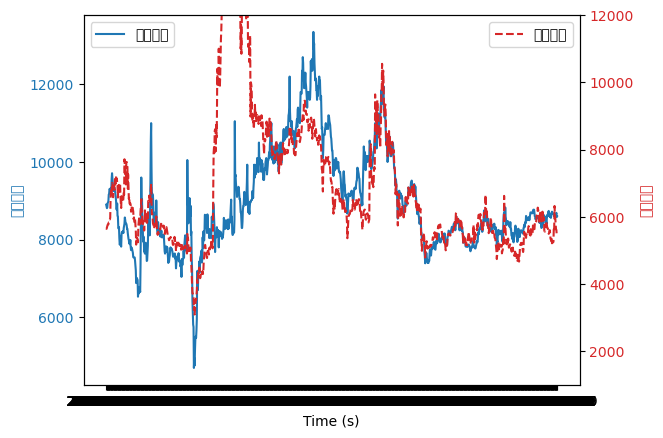

In [102]:
# 첫 번째 y축 설정
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(tickers[0], color=color)
ax1.plot(df[tickers[0]], label=tickers[0], linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 레전드 추가
ax1.legend(loc='upper left')

# 두 번째 y축 설정
ax2 = ax1.twinx()  # 같은 x축을 공유하는 새로운 y축 생성
color = 'tab:red'
ax2.set_ylabel(tickers[1], color=color)
ax2.plot(df[tickers[1]], label=tickers[1], linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([1000, 12000])
# 두 번째 레전드 추가
ax2.legend(loc='upper right')

# 차트 보여주기
plt.show()

Text(0, 0.5, '한성기업')

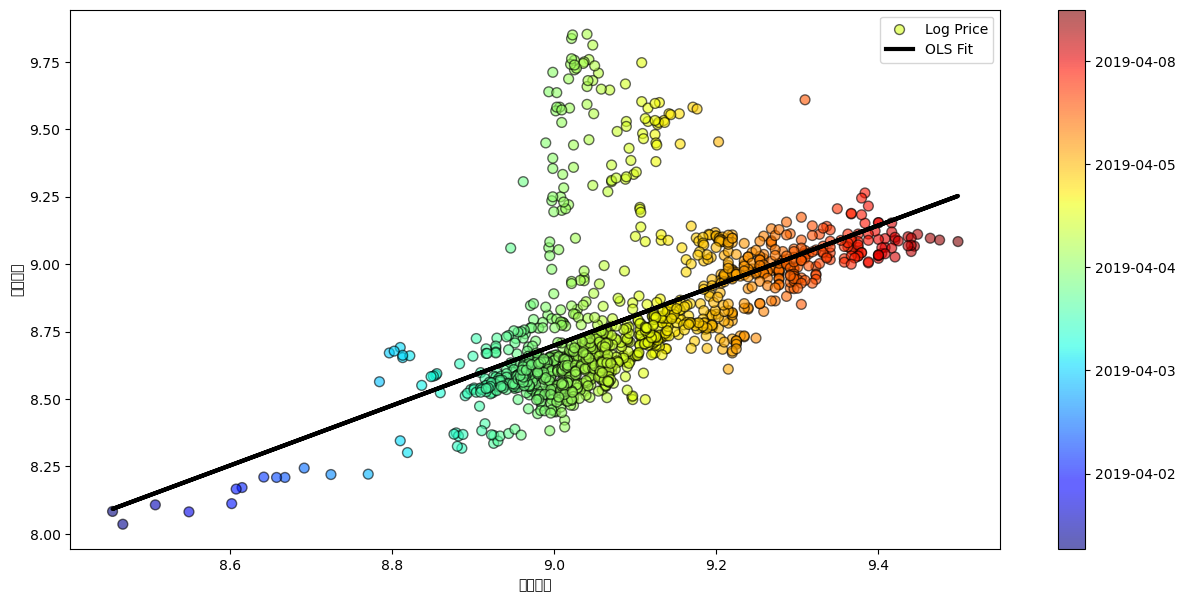

In [103]:
import statsmodels
import statsmodels.api as sm
x = list(np.log(df[tickers[0]]))
x_const = sm.add_constant(x)
y = list(np.log(df[tickers[1]]))
linear_reg = sm.OLS(y,x_const)
results = linear_reg.fit()
beta = results.params[1]
alpha = results.params[0]
y_pred = np.log(df[tickers[0]])*beta + alpha

plt.figure(figsize =(15,7))
cm = plt.get_cmap('jet')
sc = plt.scatter(np.log(df[tickers[0]]), np.log(df[tickers[1]]), s=50, c=x, cmap=cm, marker='o',
                 alpha=0.6,label='Log Price',edgecolor='k')
plt.plot(x, y_pred, '-',c='black',linewidth=3, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p) for p in df[tickers[0]].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1])

Text(0, 0.5, 'spread')

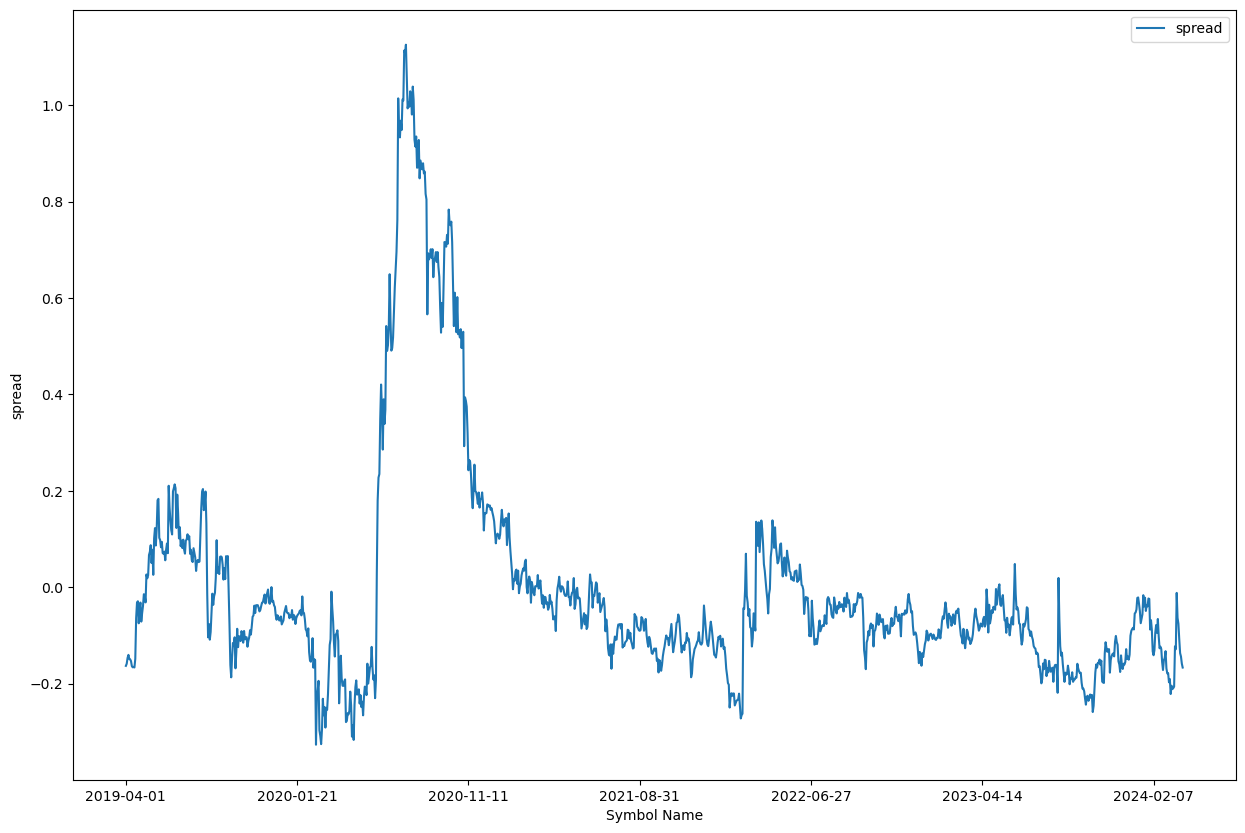

In [104]:
df2 = pd.DataFrame(np.log(df[tickers[1]]) - np.log(df[tickers[0]])*beta-alpha,index=df[tickers[0]].index)
df2.columns = ['spread']
df2.plot(figsize =(15,10))
plt.ylabel('spread')

여기 밑으로 일단 넘어가지말것

Text(0, 0.5, '한성기업')

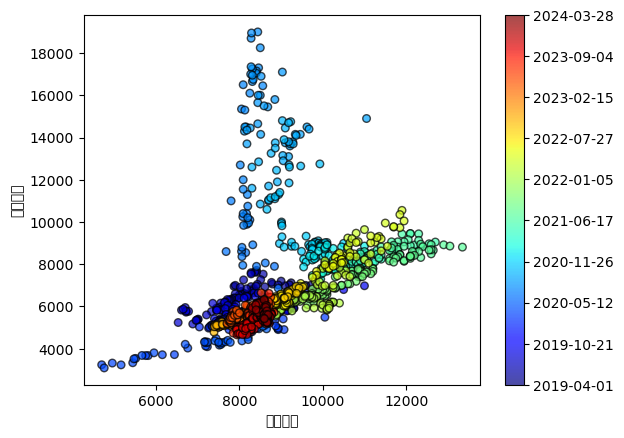

In [112]:
colors = np.linspace(0.1, 1, len(df))
sc = plt.scatter(df[tickers[0]], df[tickers[1]], s=30,
                 c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([p for p in df[::len(df)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1])

In [117]:
selected_results = [
    result for result in results_sorted 
    if result['adf_statistic'] < result['critical_values']['10%']*0.97
]
selected_results

[{'columns': ['사조오양', '한성기업'],
  'adf_statistic': -2.9532873978307097,
  'p_value': 0.03949307816218982,
  'critical_values': {'1%': -3.4357346726088136,
   '5%': -2.863917819294165,
   '10%': -2.568035988607032}},
 {'columns': ['한성기업', '동원수산'],
  'adf_statistic': -2.782497231978023,
  'p_value': 0.0608177355209771,
  'critical_values': {'1%': -3.435752466943879,
   '5%': -2.8639256700182405,
   '10%': -2.5680401696175466}},
 {'columns': ['사조산업', '사조오양'],
  'adf_statistic': -2.534271959962106,
  'p_value': 0.10735667463923004,
  'critical_values': {'1%': -3.435673305025808,
   '5%': -2.863890744031555,
   '10%': -2.56802156936202}}]

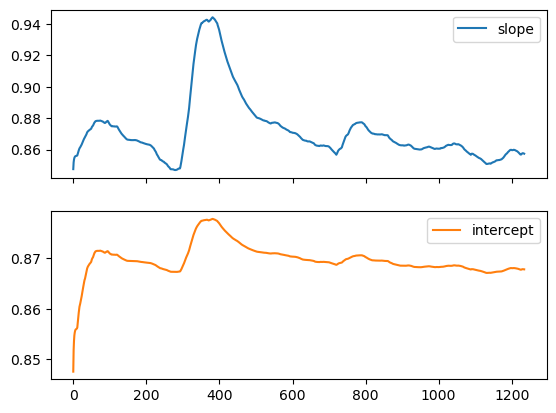

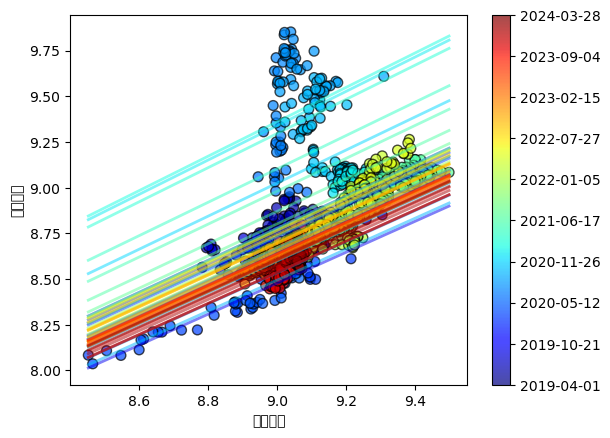

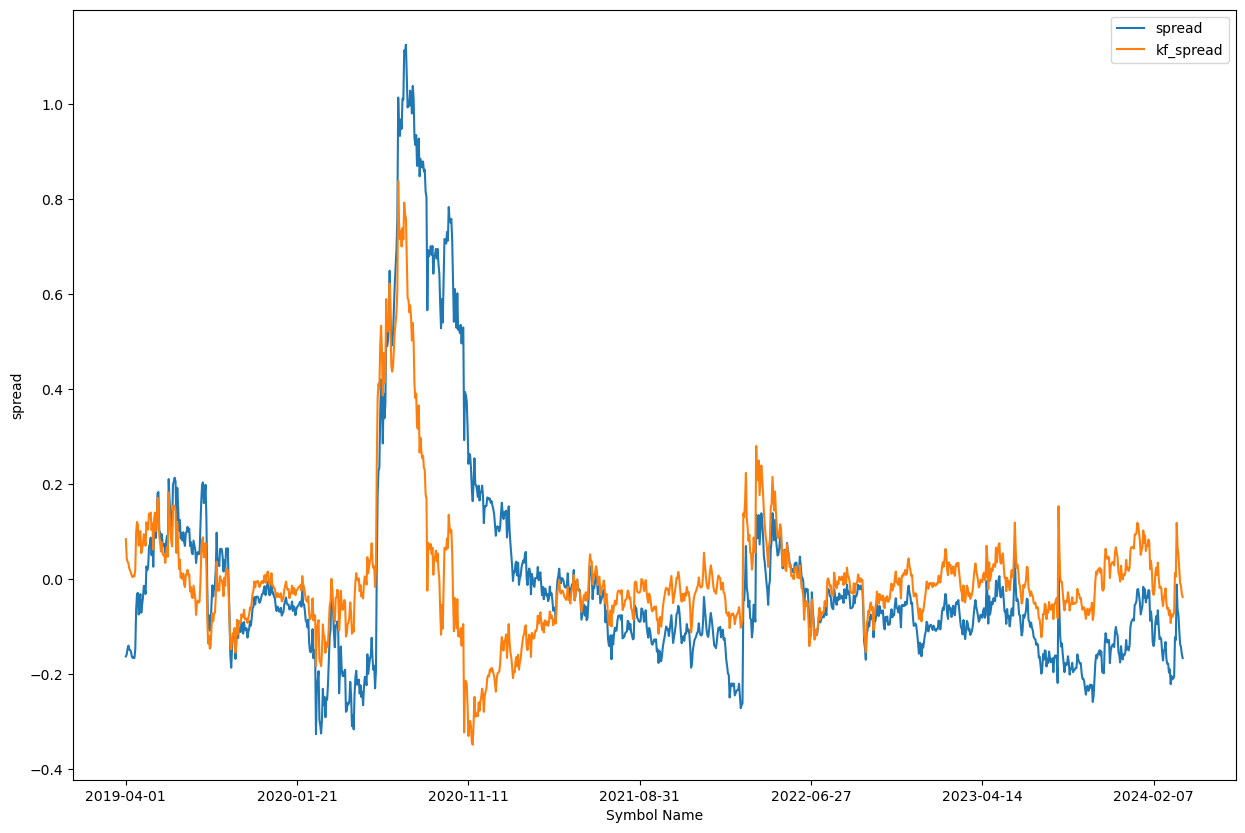

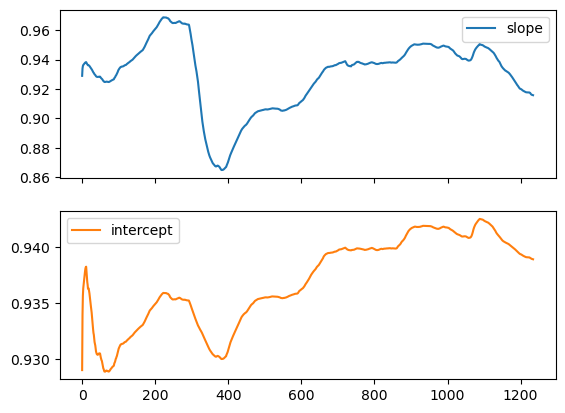

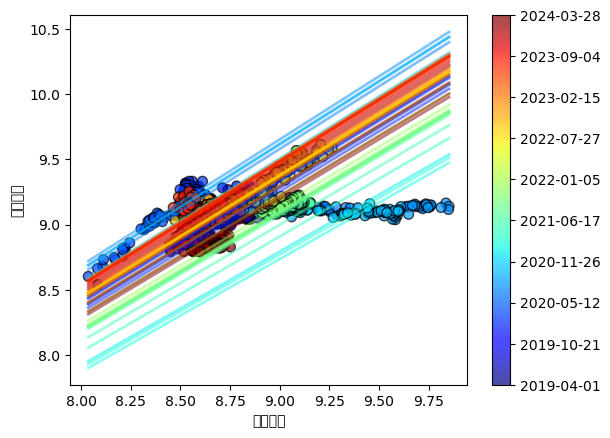

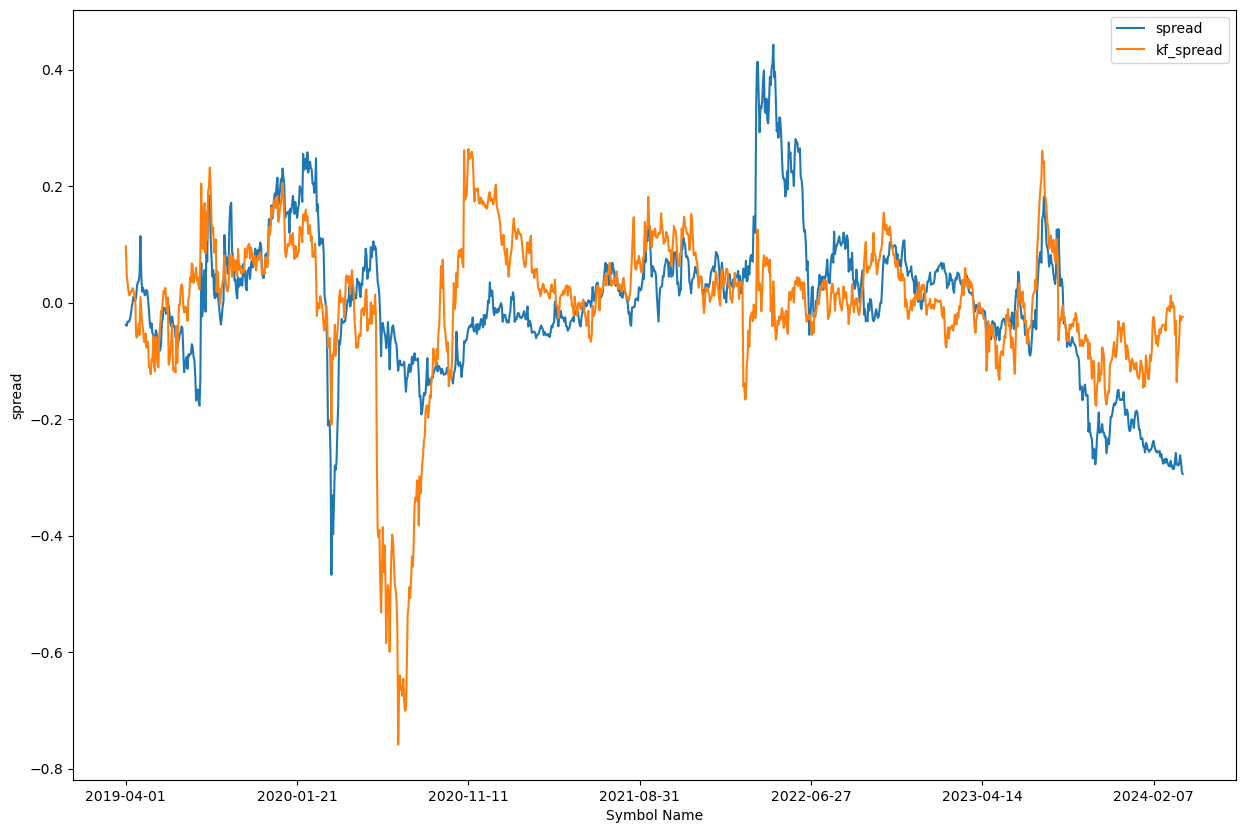

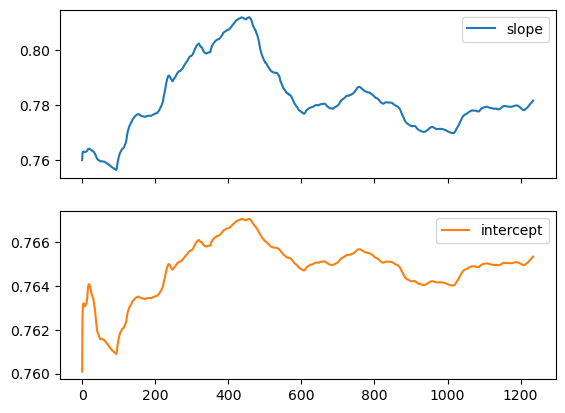

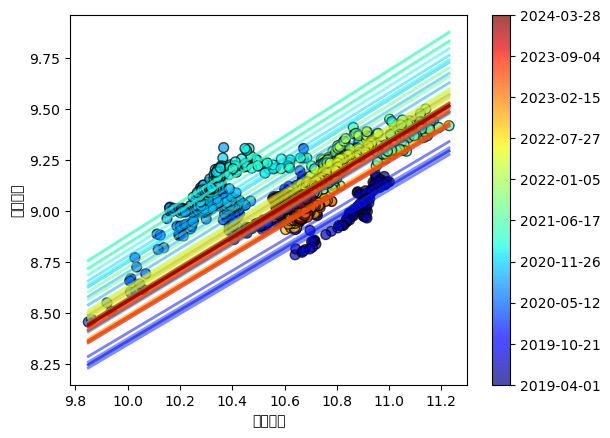

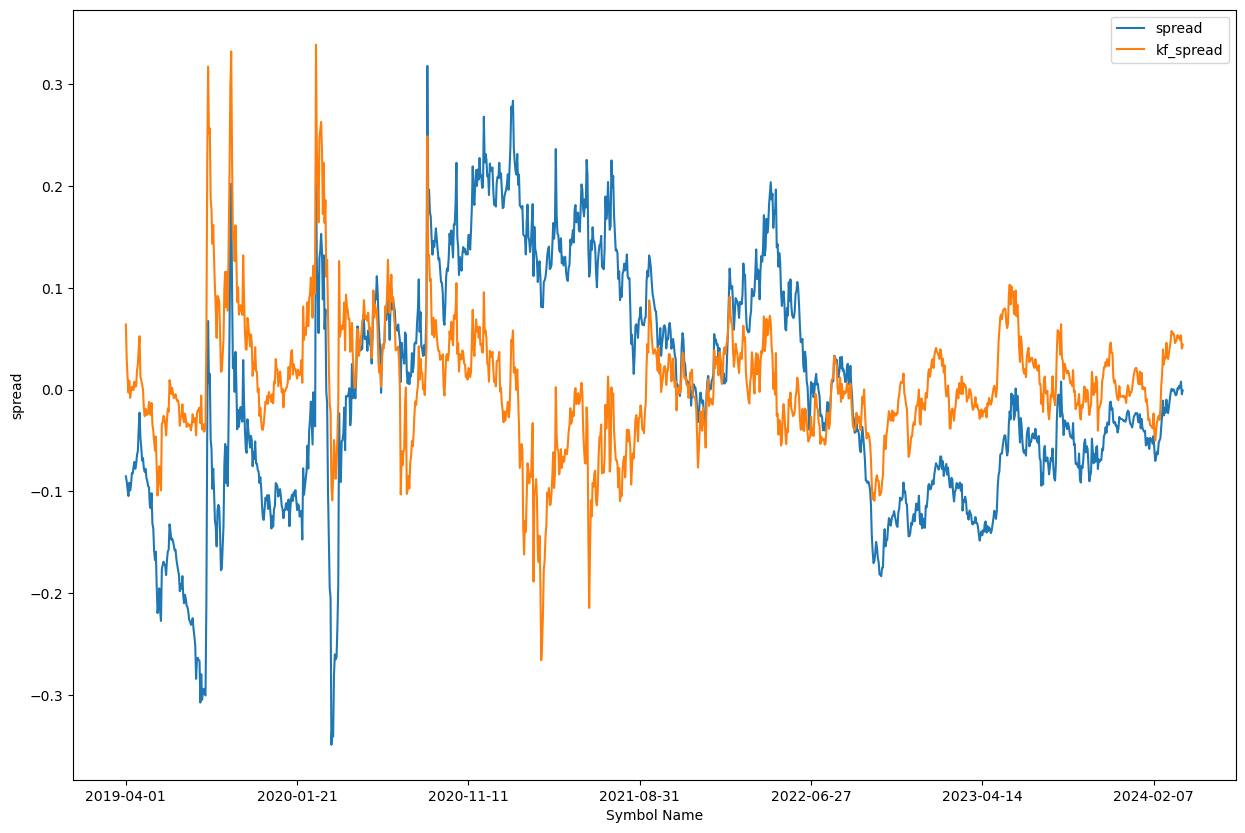

In [118]:
from pykalman import KalmanFilter
import statsmodels
import statsmodels.api as sm

stat_all = []; spread_all=[]
plt.rcParams['font.family'] = 'sans-serif'
for i in range(len(selected_results)):
    tickers = selected_results[i]['columns']
    obs_mat = sm.add_constant(np.log(df[tickers[0]].values), prepend=False)[:, np.newaxis]
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)

    # y is 1-dimensional, (alpha, beta) is 2-dimensional
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                    initial_state_mean=np.zeros(2),
                    initial_state_covariance=np.ones((2, 2)),
                    transition_matrices=np.eye(2),
                    observation_matrices=obs_mat,
                    observation_covariance=1.0,
                    transition_covariance=trans_cov)

    state_means, state_covs = kf.filter(np.log(df[tickers[1]]))
    beta_kf = pd.DataFrame(state_means, columns=['slope', 'intercept'])  # 회귀 계수 저장
    beta_kf.plot(subplots=True) 
    plt.show()

    # visualize the correlation between assest prices over time
    dates = [p for p in df[::int(len(df)/10)].index] # str(p.date())
    colors = np.linspace(0.1, 1, len(df))
    sc = plt.scatter(np.log(df[tickers[0]]), np.log(df[tickers[1]]),
                    s=50, c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
    cb = plt.colorbar(sc)
    cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())
    plt.xlabel(tickers[0])
    plt.ylabel(tickers[1])

    # add regression lines
    step = 25
    xi = np.linspace(np.log(df[tickers[0]].min()), np.log(df[tickers[0]].max()), 2)
    colors_l = np.linspace(0.1, 1, len(state_means[::step]))
    for i, b in enumerate(state_means[::step]):
        plt.plot(xi, b[0] * xi + b[1], alpha=.5, lw=2, c=plt.get_cmap('jet')(colors_l[i]))
    plt.show()

    x = list(np.log(df[tickers[0]]))
    x_const = sm.add_constant(x)
    y = list(np.log(df[tickers[1]]))
    linear_reg = sm.OLS(y,x_const)
    results = linear_reg.fit()
    beta = results.params[1]
    alpha = results.params[0]
    y_pred = np.log(df[tickers[0]])*beta + alpha

    df2 = pd.DataFrame(np.log(df[tickers[1]]) - np.log(df[tickers[0]])*beta-alpha,index=df[tickers[0]].index)
    df2.columns = ['spread']
    df2.plot(figsize =(15,10))   


    beta_kf.index = df.index
    spread_kf = np.log(df[tickers[1]]) - np.log(df[tickers[0]]) * beta_kf['slope'] - beta_kf['intercept']
    spread_all.append([spread_kf])
    spread_kf.plot(label = 'kf_spread')
    
    stat_all.append([tickers,state_means,state_covs])

    plt.ylabel('spread') 
    plt.legend()
    plt.show()

In [119]:
def asset_selection(sets):    
    first_pair = sets[0]['columns']  # 가장 연관성이 큰 첫 번째 쌍
    asset1 = set()  # 첫 번째 그룹
    asset2 = set()  # 두 번째 그룹

    asset1.add(first_pair[0])  # 첫 번째 요소를 asset1에 추가
    asset2.add(first_pair[1])  # 두 번째 요소를 asset2에 추가

    # 나머지 쌍을 그룹에 배치
    for pair in sets[1:]:
        a, b = pair['columns']

        if a in asset1 and b in asset2:
            continue  # 이미 다른 그룹에 배치된 경우 건너뜀
        elif a in asset2 and b in asset1:
            continue  # 이미 다른 그룹에 배치된 경우 건너뜀
        elif a in asset1:
            asset2.add(b)  # a가 asset1에 있으면 b를 asset2에 배치
        elif a in asset2:
            asset1.add(b)  # a가 asset2에 있으면 b를 asset1에 배치
        elif b in asset1:
            asset2.add(a)  # b가 asset1에 있으면 a를 asset2에 배치
        elif b in asset2:
            asset1.add(a)  # b가 asset2에 있으면 a를 asset1에 배치
        else:
            # a, b 모두 기존 그룹에 속하지 않은 경우 서로 다른 그룹에 배치
            asset1.add(a)
            asset2.add(b)

    # 결과 출력
    print("Asset 1:", list(asset1))  # 첫 번째 그룹의 요소
    print("Asset 2:", list(asset2))  # 두 번째 그룹의 요소
    return asset1, asset2
asset1, asset2 = asset_selection(selected_results)

Asset 1: ['동원수산', '사조오양']
Asset 2: ['사조산업', '한성기업']


각 페어쌍들의 스프레드를 다 더해라 -> (statistics비중 * (한국, 삼성 스프레드) + statistics비중 *(nh + 키움 스프레드 ...)) -> many to many를 한 포트 폴리오의 스프레드 이 스프레드를 시각화 하고 -> 2표준편차 끄어서 매수라인을 잡고 백테스트 돌린다. 

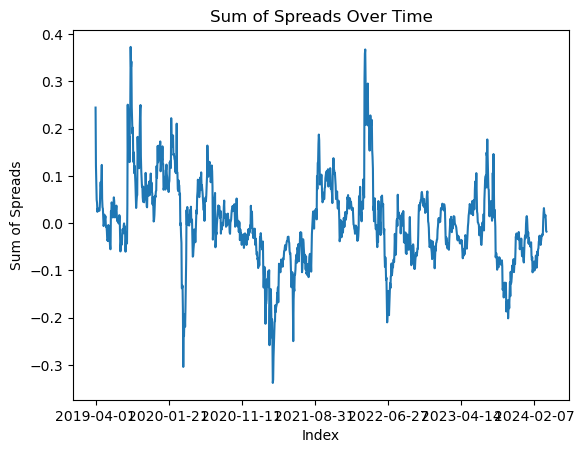

In [120]:
sum_spreads = np.sum(spread_all, axis=0)
sum_spreads_series = pd.Series(sum_spreads[0])
sum_spreads_series.index = df.index
# 시각화
sum_spreads_series.plot()
plt.title('Sum of Spreads Over Time')
plt.xlabel('Index')
plt.ylabel('Sum of Spreads')
plt.show()

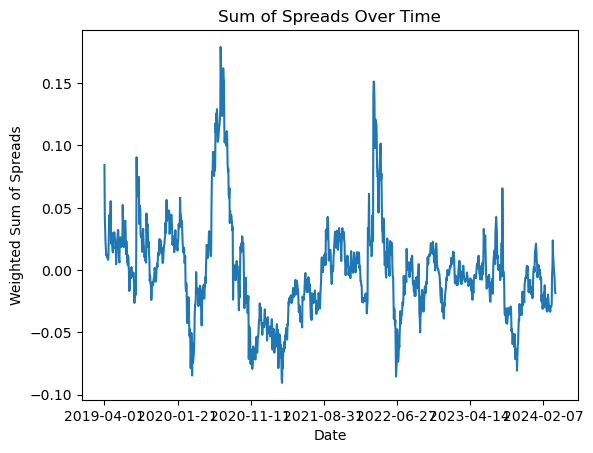

In [121]:
total_inverse_p_value = sum(1 / item['p_value'] for item in selected_results)
for item in selected_results:
    item['ratio'] = (1 / item['p_value']) / total_inverse_p_value
ratios = np.array([item['ratio'] for item in selected_results])  # 이제 numpy 배열로 변환하여 문제 해결 시도
spread_series = [pd.Series(spread) for spread in spread_all]
weighted_spreads = [spread_series[i][0] * ratios[i] for i in range(len(spread_series))]
weighted_sum_spreads = pd.concat(weighted_spreads, axis=1).sum(axis=1)
weighted_sum_spreads_series = pd.Series(weighted_sum_spreads)
weighted_sum_spreads_series.plot()
plt.title('Sum of Spreads Over Time')
plt.xlabel('Date')
plt.ylabel('Weighted Sum of Spreads')
plt.show()

In [122]:
# 투자 신호 감지 로직에 "Close" 포지션 추가
mean_spread = weighted_sum_spreads_series.mean()
std_spread = weighted_sum_spreads_series.std()
upper_bound = mean_spread + 2 * std_spread
lower_bound = mean_spread - 2 * std_spread
close_range = std_spread * 0.1
# 상태 플래그
above = False
below = False
keep = False
signals = []

for date, value in weighted_sum_spreads_series.items():
    if value > upper_bound:
        above = True
    elif value < lower_bound:
        below = True
    elif keep and(mean_spread - close_range <= value <= mean_spread + close_range):
        for index, ratio in enumerate(ratios):
            signals.append({
                'Date': date,
                'asset1': selected_results[index]['columns'][0],
                'asset2': selected_results[index]['columns'][1],
                'Investment Amount': ratio,
                'Investment Type': 'Close'
            })
        keep = False
    elif (keep == 0) and above and value <= upper_bound:
        # 위에서 아래로 내려왔을 때 매수 신호 (Long)
        for index, ratio in enumerate(ratios):
            signals.append({
                'Date': date,
                'asset1': selected_results[index]['columns'][0],
                'asset2': selected_results[index]['columns'][1],
                'Investment Amount': ratio,
                'Investment Type': 'Long'
            })
        above = False  # 상태 리셋
        keep = True
    elif (keep == 0)and below and value >= lower_bound:
        # 아래에서 위로 올라왔을 때 매도 신호 (Short)
        for index, ratio in enumerate(ratios):
            signals.append({
                'Date': date,
                'asset1': selected_results[index]['columns'][0],
                'asset2': selected_results[index]['columns'][1],
                'Investment Amount': ratio,
                'Investment Type': 'Short'
            })
        keep = True
        below = False  # 상태 리셋

# 데이터프레임으로 변환
signals_df = pd.DataFrame(signals)
signals_df


,Date,asset1,asset2,Investment Amount,Investment Type
0,2019-04-02,사조오양,한성기업,0.495728,Long
1,2019-04-02,한성기업,동원수산,0.321910,Long
2,2019-04-02,사조산업,사조오양,0.182362,Long
3,2019-07-08,사조오양,한성기업,0.495728,Close
4,2019-07-08,한성기업,동원수산,0.321910,Close
...,...,...,...,...,...
61,2023-10-27,한성기업,동원수산,0.321910,Short
62,2023-10-27,사조산업,사조오양,0.182362,Short
63,2023-12-01,사조오양,한성기업,0.495728,Close
64,2023-12-01,한성기업,동원수산,0.321910,Close


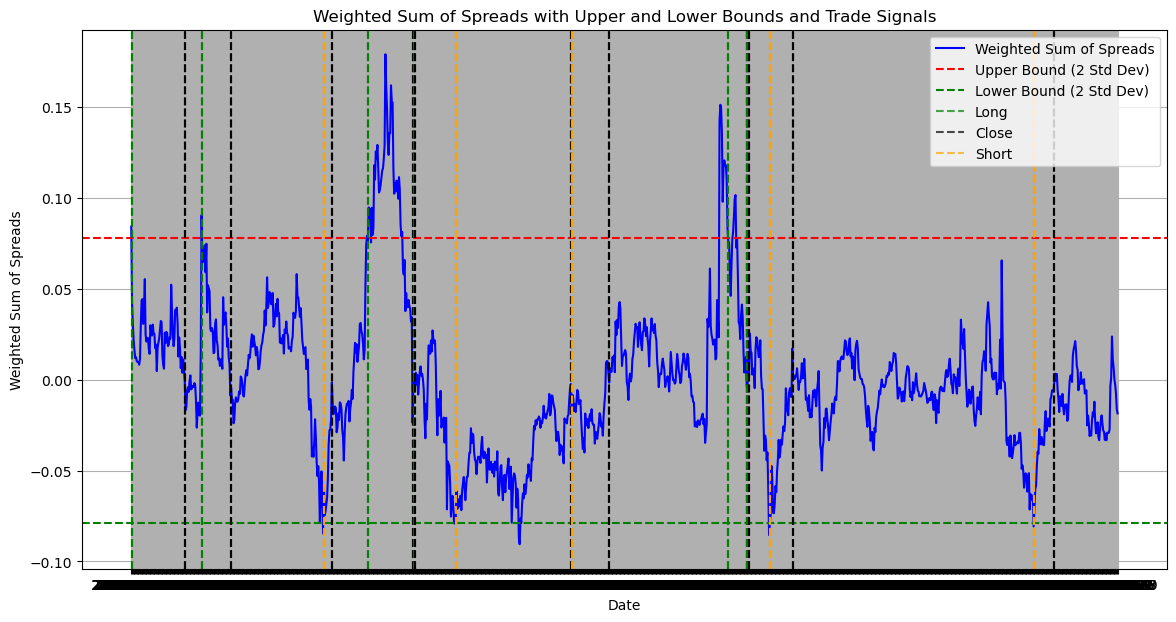

In [123]:
import matplotlib.pyplot as plt

# 가중치가 적용된 스프레드 합계 시리즈와 상한선, 하한선을 플롯
plt.figure(figsize=(14, 7))
plt.plot(weighted_sum_spreads_series, label='Weighted Sum of Spreads', color='blue')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound (2 Std Dev)')
plt.axhline(y=lower_bound, color='g', linestyle='--', label='Lower Bound (2 Std Dev)')

# 각 신호에 해당하는 날짜에 세로선을 그림, 색깔별로 구분
for index, row in signals_df.iterrows():
    if row['Investment Type'] == 'Long':
        line_color = 'green'  # Long 신호는 보라색
    elif row['Investment Type'] == 'Short':
        line_color = 'orange'  # Short 신호는 오렌지색
    elif row['Investment Type'] == 'Close':
        line_color = 'black'  # Close 신호는 회색
    plt.axvline(x=row['Date'], color=line_color, linestyle='--', alpha=0.7, label=row['Investment Type'])

# 범례와 축 레이블 추가
plt.title('Weighted Sum of Spreads with Upper and Lower Bounds and Trade Signals')
plt.xlabel('Date')
plt.ylabel('Weighted Sum of Spreads')

# 범례 중복 항목 제거
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(True)
plt.show()



In [124]:
signals_df

,Date,asset1,asset2,Investment Amount,Investment Type
0,2019-04-02,사조오양,한성기업,0.495728,Long
1,2019-04-02,한성기업,동원수산,0.321910,Long
2,2019-04-02,사조산업,사조오양,0.182362,Long
3,2019-07-08,사조오양,한성기업,0.495728,Close
4,2019-07-08,한성기업,동원수산,0.321910,Close
...,...,...,...,...,...
61,2023-10-27,한성기업,동원수산,0.321910,Short
62,2023-10-27,사조산업,사조오양,0.182362,Short
63,2023-12-01,사조오양,한성기업,0.495728,Close
64,2023-12-01,한성기업,동원수산,0.321910,Close


In [125]:
# 초기 자본 설정
initial_capital = 100000000  # 1억

# 자본 변동을 추적할 DataFrame 준비
capital_df = pd.DataFrame(index=df.index)
capital_df['capital'] = initial_capital

# 포지션을 추적할 딕셔너리
position_all = []

# 각 신호를 처리
for index, signal in signals_df.iterrows():
    date = signal['Date']
    asset1 = signal['asset1']
    asset2 = signal['asset2']
    investment_ratio = signal['Investment Amount']
    trade_type = signal['Investment Type']

    pair_index = [i for i, pairs in enumerate(selected_results) if pairs['columns'] == [asset1, asset2]][0]

    # 자본에서 투자할 금액 계산
    investment_amount = initial_capital * investment_ratio
    hedge_ratios = pd.Series(stat_all[pair_index][1][:, 0], index=pd.Series(spread_all[pair_index][0]).index)
    # 헷지 비율에 따른 투자 금액 계산
    if date in pd.Series(spread_all[pair_index][0]).index:
        hedge_ratio = hedge_ratios[date]
        amount_asset1 = investment_amount / (1 + hedge_ratio)
        amount_asset2 = amount_asset1 * hedge_ratio
    else:
        continue  # 해당 날짜에 헷지 비율 데이터가 없으면 거래를 진행하지 않음
    
    # 가격 정보
    price_asset1 = df.loc[date, asset1]
    price_asset2 = df.loc[date, asset2]
    
    # 거래 수량 계산
    quantity_asset1 = amount_asset1 / price_asset1
    quantity_asset2 = amount_asset2 / price_asset2
    positions = {}
    if trade_type == 'Long':
        # Asset1을 매수하고 Asset2를 매도
        positions[date] = {'asset1': (asset1, quantity_asset1, price_asset1,amount_asset1, 'buy'),
                           'asset2': (asset2, quantity_asset2, price_asset2,amount_asset2, 'sell')}
    elif trade_type == 'Short':
        # Asset1을 매도하고 Asset2를 매수
        positions[date] = {'asset1': (asset1, quantity_asset1, price_asset1, amount_asset1,'sell'),
                           'asset2': (asset2, quantity_asset2, price_asset2, amount_asset2,'buy')}
    elif trade_type == 'Close':
        positions[date] = {'asset1': (asset1, quantity_asset1, price_asset1,amount_asset1, 'close'),
                    'asset2': (asset2, quantity_asset2, price_asset2, amount_asset2,'close')}
    position_all.append(positions)


In [144]:
# 데이터프레임으로 변환하기 위한 빈 리스트 생성
data = []

# 각 항목을 반복하면서 데이터 추출 및 정리
for entry in position_all:
    for date, assets in entry.items():
        asset1_data = {
            'date': date,
            'asset_name': assets['asset1'][0],
            'quantity': assets['asset1'][1],
            'price': assets['asset1'][2],
            'amount': assets['asset1'][3],
            'action': assets['asset1'][4],
            'asset_type': 'asset1'
        }
        asset2_data = {
            'date': date,
            'asset_name': assets['asset2'][0],
            'quantity': assets['asset2'][1],
            'price': assets['asset2'][2],
            'amount': assets['asset2'][3],
            'action': assets['asset2'][4],
            'asset_type': 'asset2'
        }
        data.append(asset1_data)
        data.append(asset2_data)

# 데이터 리스트를 데이터프레임으로 변환
position_df = pd.DataFrame(data)

In [145]:
position_df

,date,asset_name,quantity,price,amount,action,asset_type
0,2019-04-02,사조오양,3024.730406,8850,2.676886e+07,buy,asset1
1,2019-04-02,한성기업,4043.249039,5640,2.280392e+07,sell,asset2
2,2019-04-02,한성기업,2951.300051,5640,1.664533e+07,buy,asset1
3,2019-04-02,동원수산,1826.749666,8510,1.554564e+07,sell,asset2
4,2019-04-02,사조산업,195.211663,53000,1.034622e+07,buy,asset1
...,...,...,...,...,...,...,...
127,2023-12-01,한성기업,4030.905659,5660,2.281493e+07,close,asset2
128,2023-12-01,한성기업,2941.779586,5660,1.665047e+07,close,asset1
129,2023-12-01,동원수산,2091.588087,7430,1.554050e+07,close,asset2
130,2023-12-01,사조산업,251.763099,40700,1.024676e+07,close,asset1


In [179]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Timestamp, Timedelta

# 잔고 변화 계산 함수
def calculate_balance_changes(position_df, price_df):
    # 잔고 변화 데이터를 저장할 데이터프레임
    price_df.index = pd.to_datetime(price_df.index)
    balance_df = pd.DataFrame(index=price_df.index, columns=price_df.columns).fillna(0)
    temp=price_df.index[0]
    # 각 포지션에 대해 반복
    for idx, row in position_df.iterrows():
        if row['action'] in ['buy', 'sell']:
            # 해당 포지션에 대한 'close' 이벤트 찾기
            close_row = position_df[(position_df['date'] > row['date']) & (position_df['asset_name'] == row['asset_name']) & (position_df['action'] == 'close')]
            if not close_row.empty:
                close_row = close_row.iloc[0]
                # 포지션 오픈과 클로즈 날짜 사이의 가격 데이터 추출
                start_date = row['date']
                end_date = close_row['date']
                asset_prices = price_df.loc[start_date:end_date, row['asset_name']]

                # 초기 가격과 비교하여 가격 변화율 계산
                initial_price = price_df.loc[start_date, row['asset_name']]
                price_change_ratio = asset_prices / initial_price

                # 초기 투자 금액 계산 (가격 * 수량)
                initial_investment = initial_price * row['quantity']

                # 잔고 변화 계산
                if row['action'] == 'sell':
                    balance_changes = (price_change_ratio - 1) * initial_investment
                elif row['action'] == 'buy':
                    balance_changes = (1 - price_change_ratio) * initial_investment
                balance_df.loc[temp:start_date,row['asset_name']] = balance_df.loc[end_date - pd.Timedelta(days=1),row['asset_name']]
                balance_df.loc[start_date:end_date, row['asset_name']] += balance_changes
                temp = end_date

    # 총 잔고 변화 계산
    balance_df['Total Balance'] = balance_df.sum(axis=1)

    return balance_df

# 잔고 변화 계산
balance_changes = calculate_balance_changes(position_df, df)

# 잔고 변화 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(balance_changes.index, balance_changes['Total Balance'], label='Total Balance', color='blue')
plt.title('Daily Balance Changes Over Time')
plt.xlabel('Date')
plt.ylabel('Balance')   
plt.legend()
plt.grid(True)
plt.show()


TypeError: unsupported operand type(s) for -: 'str' and 'Timedelta'

In [204]:
pd.set_option('display.max_rows', None)

# 출력할 최대 열 수
pd.set_option('display.max_columns', None)

# 데이터프레임을 출력합니다.
print(balance_changes['Cumulative Balance Change'])

Symbol Name
2019-04-01    0.000000e+00
2019-04-02    0.000000e+00
2019-04-03    1.592727e+05
2019-04-04   -6.430156e+04
2019-04-05   -2.284067e+05
2019-04-08   -4.616313e+05
2019-04-09   -3.391914e+05
2019-04-10   -6.318418e+05
2019-04-11   -6.247180e+05
2019-04-12   -7.949636e+05
2019-04-15   -7.905061e+05
2019-04-16   -5.066889e+05
2019-04-17    2.085264e+05
2019-04-18    1.051896e+06
2019-04-19    1.300467e+06
2019-04-22    5.116573e+05
2019-04-23    8.998492e+05
2019-04-24    1.952797e+06
2019-04-25    6.604010e+05
2019-04-26    7.856488e+05
2019-04-29    7.472340e+05
2019-04-30    6.633803e+05
2019-05-02    3.171532e+05
2019-05-03    2.872967e+05
2019-05-07    1.164349e+06
2019-05-08    1.117374e+06
2019-05-09    1.238149e+06
2019-05-10    1.706185e+06
2019-05-13    1.755569e+06
2019-05-14    1.794252e+06
2019-05-15    1.315637e+06
2019-05-16    1.784651e+06
2019-05-17    1.169135e+06
2019-05-20    2.009276e+06
2019-05-21    2.176981e+06
2019-05-22    2.398369e+06
2019-05-23    2.

In [210]:
import pandas as pd

balance_changes['Balance Change'] = balance_changes['Total Balance'].diff()
balance_changes['Balance Change'].iloc[0] = 0
for i in range(len(balance_changes['Balance Change'])):
    if balance_changes['Total Balance'][i] == 0:
        balance_changes['Balance Change'][i] = 0
balance_changes['Cumulative Balance Change'] = balance_changes['Balance Change'].cumsum()
# 결과 확인
print(balance_changes[['Total Balance', 'Balance Change', 'Cumulative Balance Change']])


0            Total Balance  Balance Change  Cumulative Balance Change
Symbol Name                                                          
2019-04-01    0.000000e+00    0.000000e+00               0.000000e+00
2019-04-02    0.000000e+00    0.000000e+00               0.000000e+00
2019-04-03    1.592727e+05    1.592727e+05               1.592727e+05
2019-04-04   -6.430156e+04   -2.235743e+05              -6.430156e+04
2019-04-05   -2.284067e+05   -1.641052e+05              -2.284067e+05
2019-04-08   -4.616313e+05   -2.332246e+05              -4.616313e+05
2019-04-09   -3.391914e+05    1.224399e+05              -3.391914e+05
2019-04-10   -6.318418e+05   -2.926504e+05              -6.318418e+05
2019-04-11   -6.247180e+05    7.123760e+03              -6.247180e+05
2019-04-12   -7.949636e+05   -1.702456e+05              -7.949636e+05
2019-04-15   -7.905061e+05    4.457489e+03              -7.905061e+05
2019-04-16   -5.066889e+05    2.838172e+05              -5.066889e+05
2019-04-17    2.0852

<Axes: xlabel='Symbol Name'>

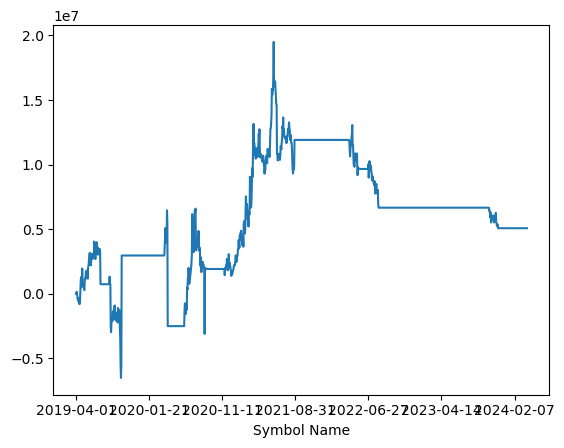

In [211]:
balance_changes['Cumulative Balance Change'].plot()